<a href="https://colab.research.google.com/github/harish-anandaramanujam/huggingface-models-in-google-colab/blob/main/week_3_day_2_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Pipelines!

The HuggingFace transformers library provides APIs at two different levels.

The High Level API for using open-source models for typical inference tasks is called "pipelines". It's incredibly easy to use.

You create a pipeline using something like:

`my_pipeline = pipeline("the_task_I_want_to_do")`

Followed by

`result = my_pipeline(my_input)`

And that's it!

See end of this colab for a list of all pipelines.

## Before we start: 2 important pro-tips for using Colab:

**Pro-tip 1:**

The top of every colab has some pip installs. You may receive errors from pip when you run this, such as:

> gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.

These pip compatibility errors can be safely ignored; and while it's tempting to try to fix them by changing version numbers, that will actually introduce real problems!

**Pro-tip 2:**

In the middle of running a Colab, you might get an error like this:

> Runtime error: CUDA is required but not available for bitsandbytes. Please consider installing [...]

This is a super-misleading error message! Please don't try changing versions of packages...

This actually happens because Google has switched out your Colab runtime, perhaps because Google Colab was too busy. The solution is:

1. Kernel menu >> Disconnect and delete runtime
2. Reload the colab from fresh and Edit menu >> Clear All Outputs
3. Connect to a new T4 using the button at the top right
4. Select "View resources" from the menu on the top right to confirm you have a GPU
5. Rerun the cells in the colab, from the top down, starting with the pip installs

And all should work great - otherwise, ask me!


## A sidenote:

You may already know this, but just in case you're not familiar with the word "inference" that I use here:

When working with Data Science models, you could be carrying out 2 very different activities: **training** and **inference**.

### 1. Training  

**Training** is when you provide a model with data for it to adapt to get better at a task in the future. It does this by updating its internal settings - the parameters or weights of the model. If you're Training a model that's already had some training, the activity is called "fine-tuning".

### 2. Inference

**Inference** is when you are working with a model that has _already been trained_. You are using that model to produce new outputs on new inputs, taking advantage of everything it learned while it was being trained. Inference is also sometimes referred to as "Execution" or "Running a model".

All of our use of APIs for GPT, Claude and Gemini in the last weeks are examples of **inference**. The "P" in GPT stands for "Pre-trained", meaning that it has already been trained with data (lots of it!) In week 6 we will try fine-tuning GPT ourselves.
  
The pipelines API in HuggingFace is only for use for **inference** - running a model that has already been trained. In week 7 we will be training our own model, and we will need to use the more advanced HuggingFace APIs that we look at in the up-coming lecture.

I recorded this playlist on YouTube with more on parameters, training and inference:  
https://www.youtube.com/playlist?list=PLWHe-9GP9SMMdl6SLaovUQF2abiLGbMjs


In [1]:
# if this gives an "ERROR" about pip dependency conflicts, ignore it! It doesn't affect anything.

!pip install -q --upgrade torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124

!pip install -q --upgrade transformers==4.48.3 datasets==3.2.0 diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.2/908.2 MB 843.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 113.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Imports

import torch
from google.colab import userdata
from huggingface_hub import login
from transformers import pipeline
from diffusers import DiffusionPipeline
from datasets import load_dataset
import soundfile as sf
from IPython.display import Audio

# Important Note

I didn't mention this in the lecture, but you may need to log in to the HuggingFace hub if you've not done so before.

1. If you haven't already done so, create a **free** HuggingFace account at https://huggingface.co and navigate to Settings from the user menu on the top right. Then Create a new API token, giving yourself write permissions.

**IMPORTANT** when you create your HuggingFace API key, please be sure to select read and write permissions for your key by clicking on the WRITE tab, otherwise you may get problems later.

2. Back here in colab, press the "key" icon on the side panel to the left, and add a new secret:  
  In the name field put `HF_TOKEN`  
  In the value field put your actual token: `hf_...`  
  Ensure the notebook access switch is turned ON.

3. Execute the cell below to log in. You'll need to do this on each of your colabs. It's a really useful way to manage your secrets without needing to type them into colab. There's also a shortcut to simply overwrite the line below with:  
`hf_token = "hf_...."`  
But this isn't a best practice, as you'd have to be careful not to share the colab. And one of the great things about colabs is that you can share them!

In [3]:
hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

In [4]:
# Sentiment Analysis

classifier = pipeline("sentiment-analysis", device="cuda")
result = classifier("I'm super excited to be on the way to LLM mastery!")
print(result)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda


[{'label': 'POSITIVE', 'score': 0.9993460774421692}]


In [5]:
# Named Entity Recognition

ner = pipeline("ner", grouped_entities=True, device="cuda")
result = ner("Barack Obama was the 44th president of the United States.")
print(result)

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496 (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda


[{'entity_group': 'PER', 'score': np.float32(0.99918306), 'word': 'Barack Obama', 'start': 0, 'end': 12}, {'entity_group': 'LOC', 'score': np.float32(0.9986908), 'word': 'United States', 'start': 43, 'end': 56}]


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="AggregationStrategy.SIMPLE"` instead.
  warnings.warn(


In [6]:
# Question Answering with Context

question_answerer = pipeline("question-answering", device="cuda")
result = question_answerer(question="Who was the 44th president of the United States?", context="Barack Obama was the 44th president of the United States.")
print(result)

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda


{'score': 0.9889456033706665, 'start': 0, 'end': 12, 'answer': 'Barack Obama'}


In [7]:
# Text Summarization

summarizer = pipeline("summarization", device="cuda")
text = """The Hugging Face transformers library is an incredibly versatile and powerful tool for natural language processing (NLP).
It allows users to perform a wide range of tasks such as text classification, named entity recognition, and question answering, among others.
It's an extremely popular library that's widely used by the open-source data science community.
It lowers the barrier to entry into the field by providing Data Scientists with a productive, convenient way to work with transformer models.
"""
summary = summarizer(text, max_length=50, min_length=25, do_sample=False)
print(summary[0]['summary_text'])

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Device set to use cuda


 The Hugging Face transformers library is an incredibly versatile and powerful tool for natural language processing . It allows users to perform a wide range of tasks such as text classification, named entity recognition, and question answering .


In [8]:
# Translation

translator = pipeline("translation_en_to_fr", device="cuda")
result = translator("The Data Scientists were truly amazed by the power and simplicity of the HuggingFace pipeline API.")
print(result[0]['translation_text'])

No model was supplied, defaulted to google-t5/t5-base and revision a9723ea (https://huggingface.co/google-t5/t5-base).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda


Les Data Scientists ont été vraiment étonnés par la puissance et la simplicité de l'API du pipeline HuggingFace.


In [9]:
# Another translation, showing a model being specified
# All translation models are here: https://huggingface.co/models?pipeline_tag=translation&sort=trending

translator = pipeline("translation_en_to_es", model="Helsinki-NLP/opus-mt-en-es", device="cuda")
result = translator("The Data Scientists were truly amazed by the power and simplicity of the HuggingFace pipeline API.")
print(result[0]['translation_text'])

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cuda


Los científicos de datos estaban verdaderamente sorprendidos por el poder y la simplicidad de la API de tuberías HuggingFace.


In [10]:
# Classification

classifier = pipeline("zero-shot-classification", device="cuda")
result = classifier("Hugging Face's Transformers library is amazing!", candidate_labels=["technology", "sports", "politics"])
print(result)

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda


{'sequence': "Hugging Face's Transformers library is amazing!", 'labels': ['technology', 'sports', 'politics'], 'scores': [0.9493839740753174, 0.03225007280707359, 0.018365919589996338]}


In [11]:
# Text Generation

generator = pipeline("text-generation", device="cuda")
result = generator("If there's one thing I want you to remember about using HuggingFace pipelines, it's")
print(result[0]['generated_text'])

No model was supplied, defaulted to openai-community/gpt2 and revision 607a30d (https://huggingface.co/openai-community/gpt2).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


If there's one thing I want you to remember about using HuggingFace pipelines, it's that you still have to use it in some ways, if you wish to use it properly for creating things (i.e. for writing your code,


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/681M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/1.73G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

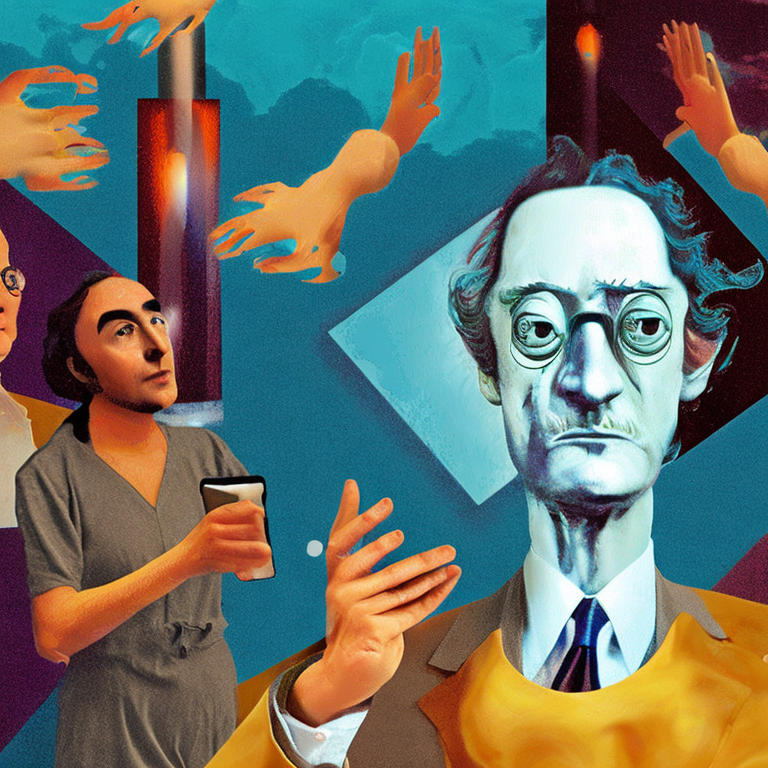

In [12]:
# Image Generation

image_gen = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16"
    ).to("cuda")

text = "A class of Data Scientists learning about AI, in the surreal style of Salvador Dali"
image = image_gen(prompt=text).images[0]
image

In [13]:
# Audio Generation

synthesiser = pipeline("text-to-speech", "microsoft/speecht5_tts", device='cuda')

embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embedding = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

speech = synthesiser("Hi to an artificial intelligence engineer, on the way to mastery!", forward_params={"speaker_embeddings": speaker_embedding})

sf.write("speech.wav", speech["audio"], samplerate=speech["sampling_rate"])
Audio("speech.wav")

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/585M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

Device set to use cuda


config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

cmu-arctic-xvectors.py: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/50.6M [00:00<?, ?B/s]

default/validation/0000.parquet:   0%|          | 0.00/21.3M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/7931 [00:00<?, ? examples/s]

# All the available pipelines

Here are all the pipelines available from Transformers and Diffusers.

With thanks to student Lucky P for suggesting I include this!

There's a list pipelines under the Tasks on this page (you have to scroll down a bit, then expand the parameters to see the Tasks):

https://huggingface.co/docs/transformers/main_classes/pipelines

There's also this list of Tasks for Diffusion models instead of Transformers, following the image generation example where I use DiffusionPipeline above.

https://huggingface.co/docs/diffusers/en/api/pipelines/overview

If you come up with some cool examples of other pipelines, please share them with me! It's wonderful how HuggingFace makes this advanced AI functionality available for inference with such a simple API.